In [2]:
!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "2xUbDYhsFdbWiqXU8Q9y8IAzR"

# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools as functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU

2024-06-07 16:56:34.840178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 16:56:34.840282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 16:56:34.961588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [6]:
dir(loader)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cache',
 'get_all_train_faces',
 'get_batch',
 'get_n_most_prob_faces',
 'get_train_size',
 'get_train_steps_per_epoch',
 'image_dims',
 'images',
 'labels',
 'neg_train_inds',
 'pos_train_inds',
 'train_inds']

In [7]:
examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)
print(examples)

109914


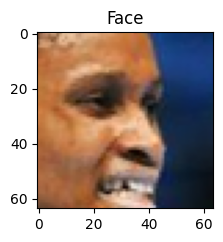

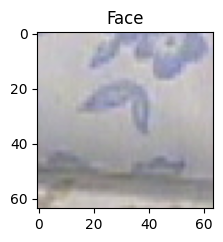

In [8]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:100, step:1}
idx_not_face = 32 #@param {type:"slider", min:0, max:100, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Face")
plt.grid(False)

In [9]:
n_filters = 12 # base number of convolutional filters


def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [10]:
def create_experiment(project_name, params):
    if 'experiment' in locals():
        experiment.end()
        
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()
    
    return experiment
    

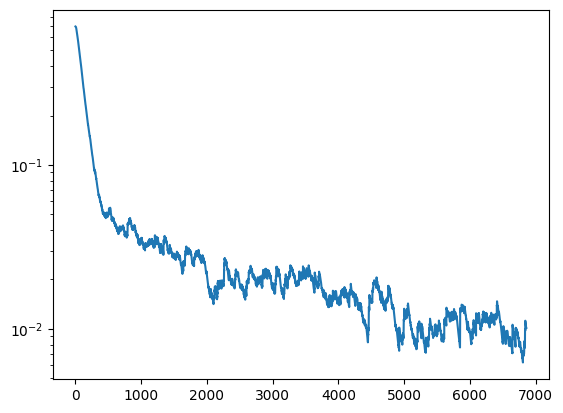

100%|██████████| 3434/3434 [00:47<00:00, 71.71it/s]


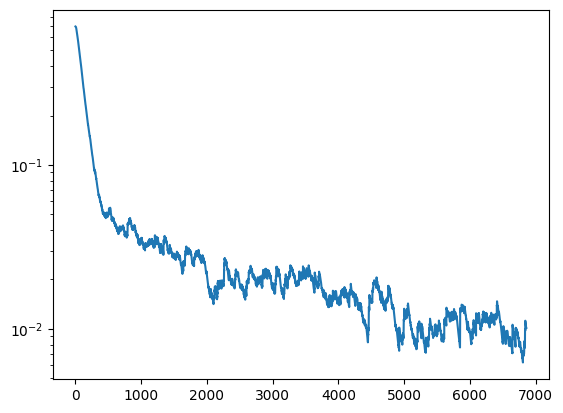

In [11]:
params = dict(
  batch_size = 32,
  num_epochs = 2,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = tf.keras.optimizers.Adam(params['learning_rate'])
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()
    
@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        logits = standard_classifier(x)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
        
    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss

step = 0

for epoch in range(params['num_epochs']):
    for idx in tqdm(range(loader.get_train_size() // params['batch_size'])):
        x, y = loader.get_batch(params['batch_size'])
        loss = standard_train_step(x, y)
        
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())
        
        experiment.log_metric('loss', loss.numpy().mean(), step=step)
        step+=1
    


In [12]:
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

 81/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1717779616.180063     163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [13]:
print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9974


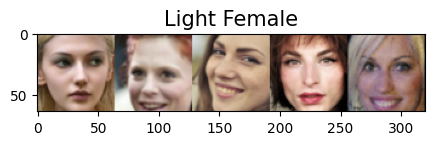

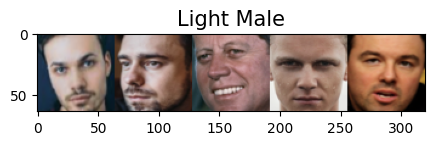

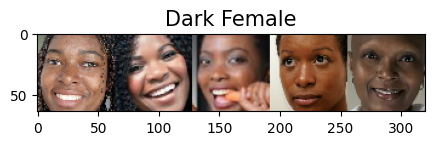

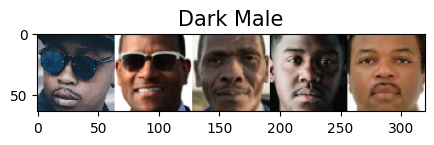

In [14]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

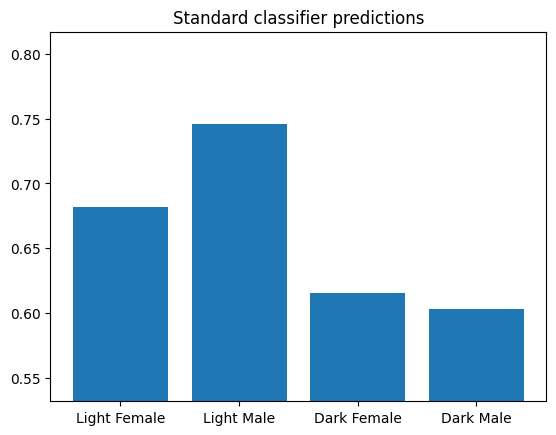

In [15]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [18]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    
    return vae_loss

In [19]:
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  
  return z

In [20]:
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss

In [21]:
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [22]:

### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)